# Permutation flow shop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/permutation_flow_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

In this notebook, we demonstrate how to model and solve permutation flow shop problems (PFSPs) using PyJobShop. The PFSP is a scheduling environment where all jobs follow the same routing through machines and must be processed in the same sequence on all machines ([Framinan et al., 2004](https://www.tandfonline.com/doi/full/10.1057/palgrave.jors.2601784); [Kalczynski & Kamburowski, 2007](https://www.sciencedirect.com/science/article/pii/S0377221706001196); [Teixeira et al., 2025](https://www.sciencedirect.com/science/article/pii/S0377221725006149?dgcid=rss_sd_all#sec4)). Besides the classic PFSP, we will also demonstrate three of its variants: the no-idle, no-wait, and blocking PFSP.

## Problem description

The classic PFSP is characterized as follows:

- There is a set of $n$ jobs that need to be processed on $m$ machines.
- All jobs follow the same routing: they are processed first on machine 1, then on machine 2, and so on until machine $m$.
- All jobs must be processed in the same sequence on all machines (permutation constraint).
- Each job has a processing time on each machine.
- The objective is typically to minimize the makespan.


We can model a PFSP using PyJobShop. For each job $j$ and each machine $k$, we define a task $T_{jk}$. We need precedence constraints to ensure that task $T_{j,k-1}$ is processed before $T_{jk}$ for $k > 1$, and sequence constraints to ensure the same job ordering on all machines.

## Data

The data for a PFSP is often given by a processing times duration matrix, like this:

In [93]:
DURATIONS = [
    [54, 79, 16, 66, 58],
    [83, 3, 89, 58, 56],
    [15, 11, 49, 31, 20],
    [71, 99, 15, 68, 85],
    [77, 56, 89, 78, 53],
    [36, 70, 45, 91, 35],
    [53, 99, 60, 13, 53],
    [38, 60, 23, 59, 41],
    [27, 5, 57, 49, 69],
    [87, 56, 64, 85, 13],
]

num_jobs, num_machines = len(DURATIONS), len(DURATIONS[0])
print(f"Problem size: {num_jobs} jobs, {num_machines} machines")

Problem size: 10 jobs, 5 machines


## Model

Let's now the model the PFSP. We start by adding all jobs and machines:

In [94]:
from pyjobshop import Model

model = Model()
jobs = [model.add_job() for _ in range(num_jobs)]
machines = [model.add_machine() for _ in range(num_machines)]

For each job and machine, we create one task and its corresponding processing mode.

In [95]:
tasks = {}  # store for later

for job_idx, job in enumerate(jobs):
    for machine_idx, machine in enumerate(machines):
        task = model.add_task(job=job)
        tasks[job_idx, machine_idx] = task

        duration = DURATIONS[job_idx][machine_idx]
        model.add_mode(task, machine, duration=duration)

We have to make sure that a job actually "flows" through the machine environment. This we can enforce by setting precedence constraints:

In [96]:
from itertools import pairwise

for job_idx in range(num_jobs):
    for idx1, idx2 in pairwise(range(num_machines)):
        task1 = tasks[job_idx, idx1]
        task2 = tasks[job_idx, idx2]
        model.add_end_before_start(task1, task2)

Finally, we impose the same sequence constraint, which ensures that all machines process all tasks in the same order:

In [97]:
for machine1, machine2 in pairwise(machines):
    model.add_same_sequence(machine1, machine2)

Let's now solve the model!

In [98]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 769.00
lower bound: 769.00
     status: Optimal
    runtime: 1.36 seconds


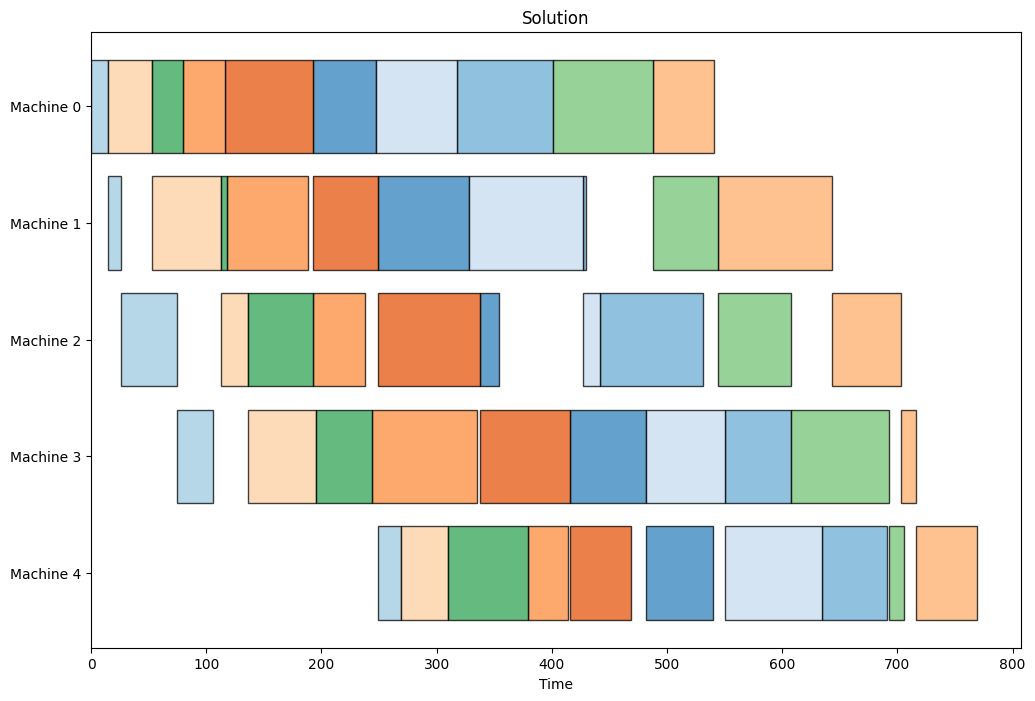

In [99]:
from pyjobshop.plot import plot_machine_gantt

plot_machine_gantt(result.best, model.data())

Perfect! Notice how all jobs "flow" through the machien environment, and how all machines process tasks in the same sequence due to the permutation constraints.

## No-idle

Let's consider a variant of the PFSP with no-idle constraints ([Kalczynski and Kamburowski (2007)](https://www.sciencedirect.com/science/article/pii/S0377221706001196)). In a no-idle PFSP, each machine must process jobs consecutively without any gaps. This is required in some factories where operating machines is expensive.

PyJobShop natively supports no-idle constraints by setting the `no_idle` parameter on the `Machine` class. The model below is almost the same as above, the only difference is that we define the machines with `no_idle=True`.

In [100]:
model = Model()

jobs = [model.add_job() for _ in range(num_jobs)]
machines = [model.add_machine(no_idle=True) for _ in range(num_machines)]
tasks = {}

for job_idx, job in enumerate(jobs):
    for machine_idx, machine in enumerate(machines):
        task = model.add_task(job=job)
        tasks[job_idx, machine_idx] = task

        duration = DURATIONS[job_idx][machine_idx]
        model.add_mode(task, machine, duration=duration)

for job_idx in range(num_jobs):
    for idx1, idx2 in pairwise(range(num_machines)):
        task1 = tasks[job_idx, idx1]
        task2 = tasks[job_idx, idx2]
        model.add_end_before_start(task1, task2)

for machine1, machine2 in pairwise(machines):
    model.add_same_sequence(machine1, machine2)

In [101]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 797.00
lower bound: 797.00
     status: Optimal
    runtime: 1.67 seconds


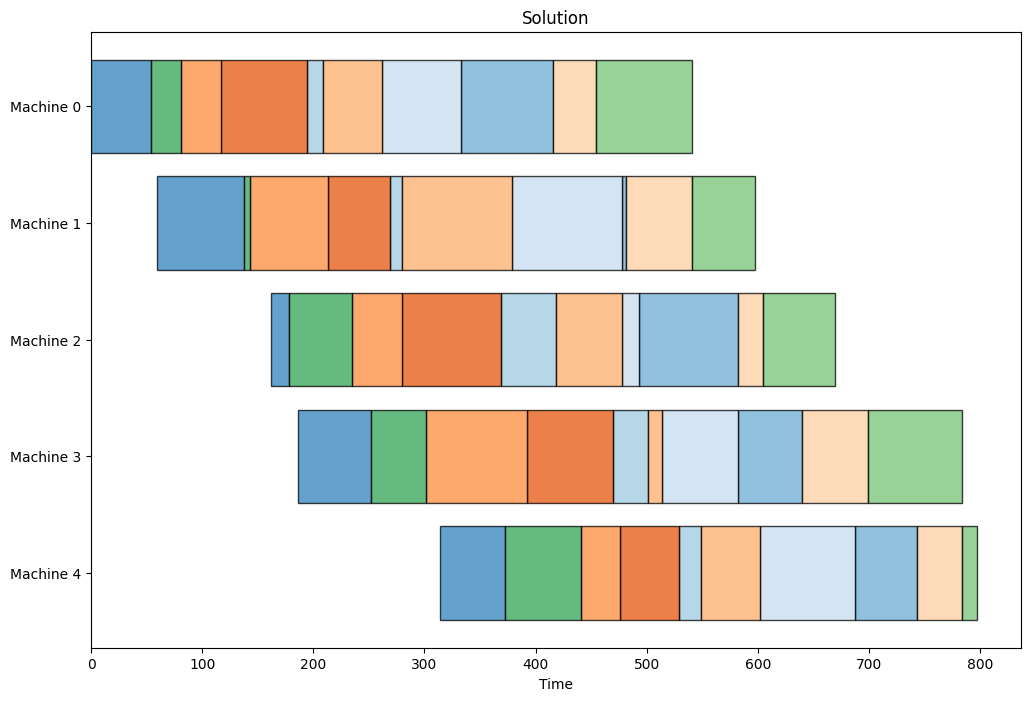

In [102]:
plot_machine_gantt(result.best, model.data())

Note how there are no idle times (gaps) between tasks on any machine. Due to the no-idle constraint, the makespan is slightly higher and a different sequence is chosen to optimize the schedule in this setting.

## No-wait

Let's now consider the no-wait PFSP. In this variant, jobs cannot wait between consecutive machines. This means that once a job starts processing, it must continue through all machines without any waiting time between operations. In practice, this may be required to ensure that a product stays at a specific temperature and does not cool down between consecutive machines.

We can model this using PyJobShop by ensuring that a task $T_{j,k-1}$ ends exactly when $T_{j,k}$ starts for all jobs $j$ and consecutive machines $k-1, k$. In addition, we don't need to explicitly add the same sequence constraints because the no-wait constraints naturally create a permutation schedule. This improves solving efficiency for OR-Tools CP-SAT, where sequencing constraints are computationally expensive. On the other hand, CP Optimizer benefits from adding permutation constraints -- both solvers use different techniques and have different strengths in handling constraint types. We leave them out here because PyJobShop uses OR-Tools CP-SAT by default.

In [103]:
model = Model()

jobs = [model.add_job() for _ in range(num_jobs)]
machines = [model.add_machine() for _ in range(num_machines)]
tasks = {}

for job_idx, job in enumerate(jobs):
    for machine_idx, machine in enumerate(machines):
        task = model.add_task(job=job)
        tasks[job_idx, machine_idx] = task

        duration = DURATIONS[job_idx][machine_idx]
        model.add_mode(task, machine, duration=duration)

for job_idx in range(num_jobs):
    for idx1, idx2 in pairwise(range(num_machines)):
        task1 = tasks[job_idx, idx1]
        task2 = tasks[job_idx, idx2]

        # This ensures end(task1) == start(task2).
        model.add_end_before_start(task1, task2)
        model.add_start_before_end(task2, task1)

In [104]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 851.00
lower bound: 851.00
     status: Optimal
    runtime: 2.41 seconds


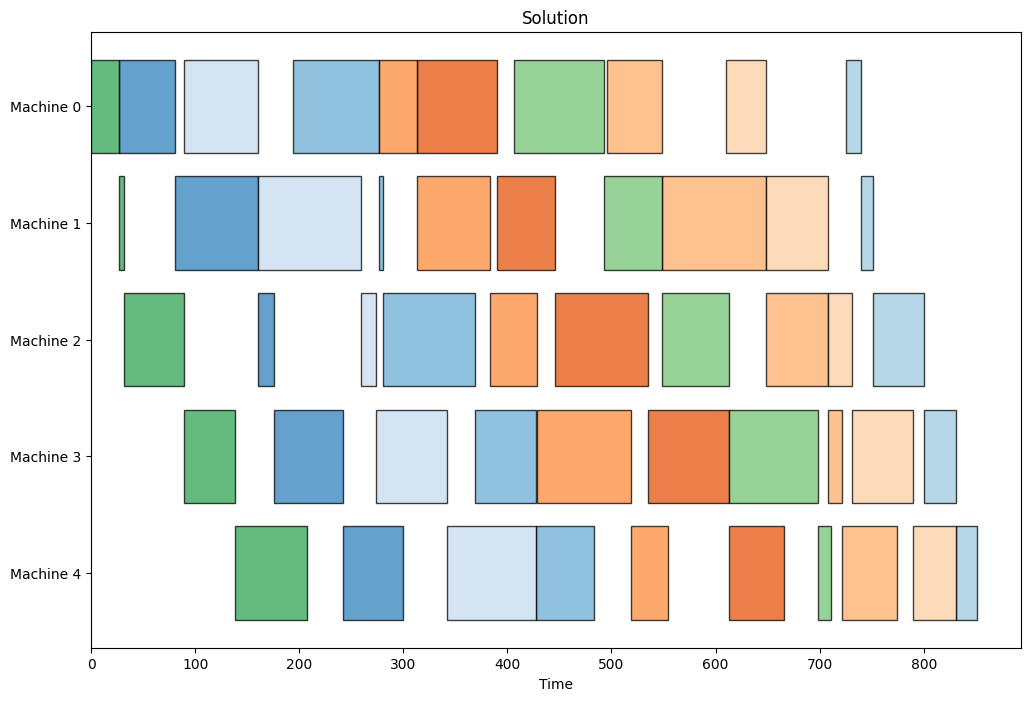

In [105]:
plot_machine_gantt(result.best, model.data())

There is no waiting time between any two consecutive tasks of the same job, and all machines naturally process jobs in the same sequence. However, the makespan is much higher than the original PFSP.

## Blocking

As the last example, we consider the blocking PFSP. In this case, jobs cannot wait between consecutive machines and will continue to occupy (block) the machine until the next machine becomes available. This means that once a job finishes processing on a machine, it cannot leave that machine until it can start processing on the next machine. For more details, see the paper by [Teixeira et al. (2025)](https://www.sciencedirect.com/science/article/pii/S0377221725006149?dgcid=rss_sd_all#sec4).

By default, PyJobShop assumes that all tasks have a fixed duration, which is given by the selected mode.
To model blocking tasks, we have to allow for variable processing durations by setting `fixed_duration=False` for tasks and using the same end-at-start constraints as in the no-wait case. 
The key difference is that tasks can now extend their duration beyond the processing time if they need to block the machine while waiting for the next stage.

Just like the no-wait variant, it's not required to add same sequence constraints here, because the blocking already naturally implies this constraint.

In [106]:
model = Model()

jobs = [model.add_job() for _ in range(num_jobs)]
machines = [model.add_machine() for _ in range(num_machines)]
tasks = {}

for job_idx, job in enumerate(jobs):
    for machine_idx, machine in enumerate(machines):
        task = model.add_task(job=job, fixed_duration=False)
        tasks[job_idx, machine_idx] = task

        duration = DURATIONS[job_idx][machine_idx]
        model.add_mode(task, machine, duration=duration)

for job_idx in range(num_jobs):
    for idx1, idx2 in pairwise(range(num_machines)):
        task1 = tasks[job_idx, idx1]
        task2 = tasks[job_idx, idx2]

        # This ensures end(task1) == start(task2).
        model.add_end_before_start(task1, task2)
        model.add_start_before_end(task2, task1)

In [107]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 791.00
lower bound: 791.00
     status: Optimal
    runtime: 2.21 seconds


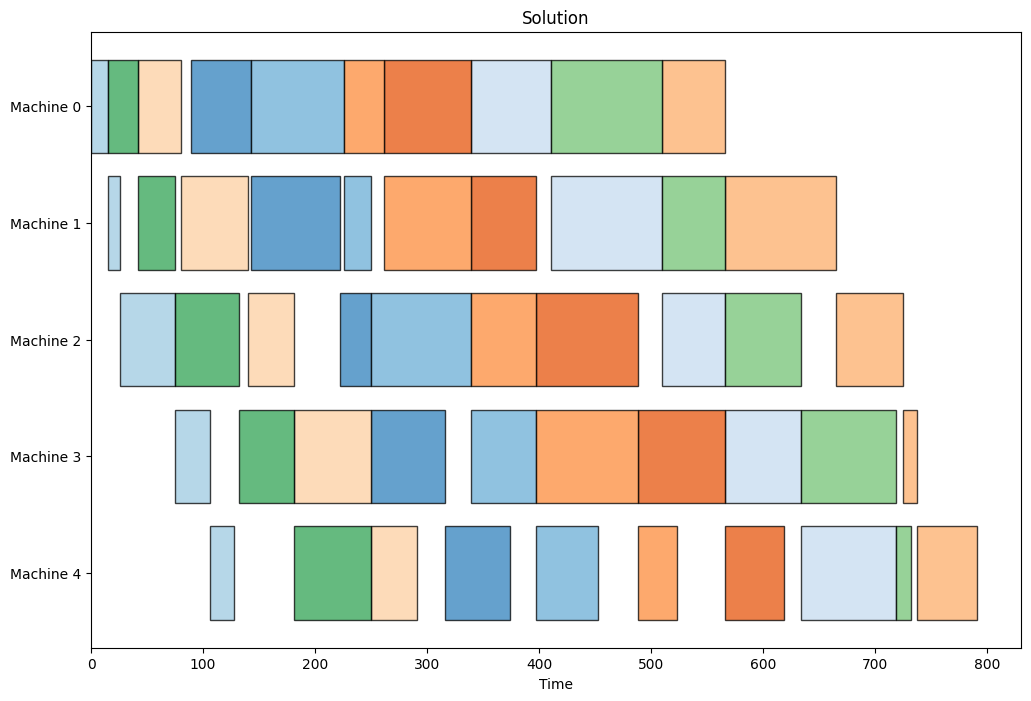

In [108]:
plot_machine_gantt(result.best, model.data())

It's a bit difficult to see in this figure, but we can verify the solution tasks are occupying machines longer than required by their processing time:

In [109]:
for sol_task in result.best.tasks[:10]:
    actual = sol_task.end - sol_task.start
    processing = model.modes[sol_task.mode].duration
    block = actual - processing

    print(f"{actual = } | {processing = } | {block = }")

actual = 54 | processing = 54 | block = 0
actual = 79 | processing = 79 | block = 0
actual = 28 | processing = 16 | block = 12
actual = 66 | processing = 66 | block = 0
actual = 58 | processing = 58 | block = 0
actual = 83 | processing = 83 | block = 0
actual = 24 | processing = 3 | block = 21
actual = 89 | processing = 89 | block = 0
actual = 58 | processing = 58 | block = 0
actual = 56 | processing = 56 | block = 0


## Conclusion

This notebook demonstrated how to model PFSP scheduling problems using PyJobShop. We showed four variants:

1. **Classic PFSP**: Uses explicit `add_same_sequence` constraints to enforce identical task sequences on all machines.
2. **No-idle PFSP**: Uses the `Machine.no_idle` parameter to eliminate machine idle time.
3. **No-wait PFSP**: Uses no-wait constraints (`add_end_before_start` + `add_start_before_end`) which naturally create a permutation schedule without expensive sequencing constraints.
4. **Blocking PFSP**: Combines no-wait constraints with variable-duration tasks (tasks with `fixed_duration=False`) to handle cases where tasks block machines while waiting.

Each variant addresses different manufacturing constraints and demonstrates the flexibility of PyJobShop's modeling capabilities.